# Project -- Analysing IRA tweets --

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
import glob
from translate import Translator
import spacy
import findspark
import nltk

import findspark
findspark.init()

from pyspark import SparkContext

from pyspark.sql import *
from pyspark.sql.functions import to_timestamp, isnan
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, when, length

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

C:\Users\Demo\Anaconda3\envs\ada\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\Demo\Anaconda3\envs\ada\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
import warnings # comment if you want to get the warnings from Searborn... ;) 
warnings.filterwarnings("ignore")

In [3]:
# set up data directory
DATA_DIR = 'data/'

There are two main parts in this current *Jupyter Notebook* :

* 1) **GETTING TO KNOW OUR MAIN DATASETS**. We intend to understand what contain our datasets (features and their dtypes) and to clean them in order to be ready for interpretation. We also may want to split or create new sub-datasets if there are interesting opportunities to do so.


* 2) **DESCRIPTIVE STATISTICS AND PROJECT FEASABILITY**. In this part of the notebook we want to give summary statistics about the datasets we will need the most for our project. Furthermore we will try to figure out whether or not our objectives of Milestone 1 are still feasible after the reading of our datasets. 

## 1. GETTING TO KNOW OUR MAIN DATASETS

### loading the data

In [4]:
# taking IRAN tweets into account or not 
include_iran = False

In [5]:
# load datasets thanks to Spark CSV reader 

if include_iran:
    
    # combine both RUS and IRAN datasets
    include_description = 'RUS & IRAN'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_user.csv')

else:
    
    # take only RUS datasets
    include_description = 'RUS'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_user.csv')

In [6]:
# look at the raw global datasets' sizes 

# n : number of observations
n_text = tweets_text_df.count()
n_stats = tweets_stats_df.count()
n_metadata = tweets_meta_df.count()
n_users = tweets_user_df.count()

# d : dimensionality of the data 
d_text = len(tweets_text_df.columns)
d_stats = len(tweets_stats_df.columns)
d_metadata = len(tweets_meta_df.columns)
d_users =  len(tweets_user_df.columns)

# print the results 
print(' Sizes of the datasets : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of troll_tweet_text : '+str((n_text,d_text)))
print('size of troll_tweet_stats : '+str((n_stats,d_stats)))
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))
print('size of troll_user : '+str((n_users,d_users)))

 Sizes of the datasets : (RUS)
 --------------------------------------------------------
size of troll_tweet_text : (9041308, 3)
size of troll_tweet_stats : (9041308, 17)
size of troll_tweet_metadata : (9041308, 6)
size of troll_user : (3667, 11)


Roughly more than 9M tweets are available from RUS datasets (10M when combining both RUS AND IRAN). If after the cleaning there remains such a large number of data points, it's most likely that our statistical tests will present some significance if there are really underlying correlations, differences ... etc. 

We can assume, since the number of records for each dataframe is the same and because of the '*a priori*' description of the data, that the rows are ordered in such a way that every tuple of index $i$ in '*troll_tweet_text*' corresponds to the observations at index $i$ for '*troll_tweet_stats*' and '*troll_tweet_metadata*'. 

### tweets_text

In [7]:
# what does tweets_text look like ? size, dtypes
print((n_text,d_text))
tweets_text_df.dtypes

(9041308, 3)


[('tweetid', 'string'), ('tweet_language', 'string'), ('tweet_text', 'string')]

In [8]:
# a quick view
tweets_text_df.show(10)

+------------------+--------------+--------------------+
|           tweetid|tweet_language|          tweet_text|
+------------------+--------------+--------------------+
|877919995476496385|            ru|"RT @ruopentwit: ...|
|492388766930444288|            ru|Серебром отколоко...|
|719455077589721089|            bg|@kpru С-300 в Ира...|
|536179342423105537|            ru|Предлагаю судить ...|
|841410788409630720|            bg|Предостережение а...|
|834365760776630272|            ru|Двойная утопия, и...|
|577490527299457024|            ru|RT @harkovnews: Н...|
|596522755379560448|            ru|RT @NovostiNsk: «...|
|567357519547207680|            en|As sun and cloud ...|
|665533117369876480|            ru|RT @vesti_news: Ш...|
+------------------+--------------+--------------------+
only showing top 10 rows



***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Unknown *tweet_language* can take both the value 'und', or null. We harmonize this column by setting all NaN to 'und'.

In [9]:
tweets_text_df = tweets_text_df.fillna('und',['tweet_language'])

### tweets_stats

In [10]:
# what does tweets_stats look like ? size, dtypes
print((n_stats,d_stats))
tweets_stats_df.dtypes

(9041308, 17)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'string'),
 ('in_reply_to_tweetid', 'string'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('is_retweet', 'string'),
 ('retweet_userid', 'string'),
 ('retweet_tweetid', 'string'),
 ('quote_count', 'string'),
 ('reply_count', 'string'),
 ('like_count', 'string'),
 ('retweet_count', 'string'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

In [11]:
# (a view is not adapted in the current context)
# tweets_stats_df.show(10)

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the *tweet_time* into Datetime for ease of use, and we cast some columns into integers. We also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [12]:
# dtypes transformations : 
tweets_stats_df = tweets_stats_df.withColumn('tweet_time', to_timestamp(tweets_stats_df.tweet_time))
tweets_stats_df = tweets_stats_df.withColumn('quote_count', tweets_stats_df.quote_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('reply_count', tweets_stats_df.reply_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('like_count', tweets_stats_df.like_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('retweet_count', tweets_stats_df.retweet_count.cast('int'))

# create a temporary Spark SQL view
tweets_stats_df.createOrReplaceTempView("tweets_stats_sql")

Now we can start splitting the data into smaller dataframes and remove the useless columns for each of those:
* **retweets_df** contains all the posts that are retweets.
* **replies_df** contains all the posts that are replies to other tweets.
* **normal_tweets_df** contains all the other ('normal') posts.

**NB:** some tweets have a value for *in_reply_to_userid* while their *in_reply_to_tweetid* is null (however the inverse never happens). Those are either replies to deleted tweets, or mentions of other users that were treated as replies. We decided to consider them as normal tweets.

In [13]:
# RETWEETS
retweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=True")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in retweets_df:
    #retweets_df.select(col).distinct().show(10)

# drop certain features
retweets_df = retweets_df.drop('in_reply_to_tweetid', 'in_reply_to_userid', 'is_retweet',\
                               'quote_count', 'reply_count', 'like_count', 'retweet_count',\
                               'poll_choices')

# record the size of the created sub-dataset
n_retweets = retweets_df.count()
d_retweets = len(retweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of retweets : '+str((n_retweets,d_retweets)))


 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of retweets : (3333184, 9)


In [14]:
# REPLIES
replies_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NOT NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in replies_df:
    #replies_df.select(col).distinct().show(10)

# record the size of the created sub-dataset
replies_df = replies_df.drop('retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_replies = replies_df.count()
d_replies = len(replies_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of replies : '+str((n_replies,d_replies)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of replies : (266208, 14)


In [15]:
# NORMAL
normal_tweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in normal_tweets_df:
    #normal_tweets_df.select(col).distinct().show(10)
    
# record the size of the created sub-dataset
normal_tweets_df = normal_tweets_df.drop('in_reply_to_tweetid', 'retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_normal = normal_tweets_df.count()
d_normal = len(normal_tweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of normal tweets : '+str((n_normal,d_normal)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of normal tweets : (5441916, 13)


We verify that the number of rows correspond and that we did not duplicate or remove any by accident.

In [16]:
print(str(n_stats)+' vs. '+str(n_retweets+n_normal+n_replies))

9041308 vs. 9041308


### tweets_meta

In [17]:
# what does tweets_stats look like ? size, dtypes
print((n_metadata,d_metadata))
tweets_meta_df.dtypes

(9041308, 6)


[('tweetid', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('tweet_client_name', 'string')]

In [18]:
# a quick view
tweets_meta_df.show(10)

+------------------+--------------+---------------+--------+---------+------------------+
|           tweetid|follower_count|following_count|latitude|longitude| tweet_client_name|
+------------------+--------------+---------------+--------+---------+------------------+
|849295393867399169|          4042|           1470|    null|     null|Twitter Web Client|
|567280957913587713|           272|            390|    null|     null|          iziaslav|
|493095247690612736|            89|            223|    null|     null|          vavilonX|
|493892174069903360|            89|            223|    null|     null|          vavilonX|
|512503798506721280|            89|            223|    null|     null|          vavilonX|
|499624206246871041|            89|            223|    null|     null|          vavilonX|
|491828568251707392|            89|            223|    null|     null|          vavilonX|
|493768356810731520|            89|            223|    null|     null|          vavilonX|
|502221368

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Just as with the previous dataset, we cast some columns into integers and we also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [19]:
# dtypes transformations : 
tweets_meta_df = tweets_meta_df.withColumn('follower_count', tweets_meta_df.follower_count.cast('int'))
tweets_meta_df = tweets_meta_df.withColumn('following_count', tweets_meta_df.following_count.cast('int'))

# NOTE : we do not cast lattitude/longitude columns into integers since we intend to drop both 
# columns (see below why).

# create a temporary Spark SQL view
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

It appears that the number of rows with a non-null *latitude*/*longitude* combination is very small compared to the size of dataset (less than 0.05%). Several of them are repeated. Thus we consider it rather useless and prefer dropping it.

In [20]:
temp = spark.sql("SELECT * FROM tweets_meta_sql WHERE latitude IS NOT NULL")
print('total number of observations for this data set '+str(n_metadata))
print('number of non NULL lattitude records : '+str(temp.count())+ ' and among them '+str(temp.select('latitude', 'longitude').distinct().count())+' unique coordinates pairs')

# drop lattitude and longitude 
tweets_meta_df = tweets_meta_df.drop('latitude', 'longitude')
      
# override previous TempView
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

total number of observations for this data set 9041308
number of non NULL lattitude records : 4779 and among them 2938 unique coordinates pairs


The main feature that we can use to split the data here is *tweet_client_name*. When we take a closer look to this column, we discover that there are more than 400 values registered. Many of them seem unidentifiable.

However, we can see that a good amount of tweets are sent through official Twitter applications:
* **Twitter Web Client** accounts for around one third of the tweets in the dataset.
* **TweetDeck**, which allows to manage multiple accounts simultaneously, handles around 7% of the tweets.
* **Twitter For Android** is also in the top 15 applications used for those tweets.

Most of the other tweets are generated through automated social media managers, such as **twitterfeed** (which had been shut down in 2016), **dlvr.it**, or even **IFTTT**.

In [21]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql GROUP BY tweet_client_name ORDER BY count DESC")
print('number of twitter clients : '+str(temp.count()))
temp.show(15)

number of twitter clients : 334
+-------------------+-------+
|  tweet_client_name|  count|
+-------------------+-------+
| Twitter Web Client|2576596|
|        twitterfeed|1472547|
|          TweetDeck| 612024|
|      newtwittersky| 393074|
|          bronislav| 308516|
|           iziaslav| 299963|
|              IFTTT| 291269|
|          rostislav| 289475|
|        generationπ| 285503|
|         Twibble.io| 268402|
|    Ohwee Messanger| 240051|
|NovaPress Publisher| 204583|
|Twitter for Android| 163227|
|Приложение для тебя| 159588|
|           vavilonX| 148744|
+-------------------+-------+
only showing top 15 rows



Let's have a look on Twitter clients of the kind : *Twitter ... for ....*.

In [22]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql WHERE tweet_client_name LIKE '%Twitter%' GROUP BY tweet_client_name ORDER BY count DESC")
print('number of such typical twitter clients : '+str(temp.count()))
temp.show()

number of such typical twitter clients : 18
+--------------------+-------+
|   tweet_client_name|  count|
+--------------------+-------+
|  Twitter Web Client|2576596|
| Twitter for Android| 163227|
|  Twitter for iPhone|  56168|
|Twitter for Andro...|  22126|
|    Twitter for iPad|   4432|
|Twitter for  Android|   3642|
|        Twitter Lite|   2891|
|      Twitter Nation|    813|
|Twitter for Websites|    762|
|Twitter for Nokia...|    442|
| Twitter for Windows|     92|
|Twitter for Black...|     92|
|Twitter for Black...|     71|
|Twitterrific for iOS|     21|
|Twitter for Windo...|      9|
|         Twitter Ads|      6|
|Twitter Business ...|      2|
|Unfollow Tools fo...|      1|
+--------------------+-------+



In the end, seeing how messy this dataset is, and how few columns it has, we decided to not split it.

In [23]:
# update the dimensionality of this dataset after the drop of columns
d_metadata=  len(tweets_meta_df.columns)
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))

size of troll_tweet_metadata : (9041308, 4)


### tweets_user

In [24]:
# what does tweets_stats look like ? size, dtypes
print((n_users,d_users))
tweets_user_df.dtypes

(3667, 11)


[('userid', 'string'),
 ('user_display_name', 'string'),
 ('user_screen_name', 'string'),
 ('user_reported_location', 'string'),
 ('user_profile_description', 'string'),
 ('user_profile_url', 'string'),
 ('account_creation_date', 'string'),
 ('account_language', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('last_tweet_at', 'string')]

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the dates and integers present in the dataframe. This also treats the wrong encodings in those columns (such as a language ('en') present in *last_tweet_at*.

In [25]:
# dtypes transformations : 
tweets_user_df = tweets_user_df.withColumn('account_creation_date', to_timestamp(tweets_user_df.account_creation_date))
tweets_user_df = tweets_user_df.withColumn('last_tweet_at', to_timestamp(tweets_user_df.last_tweet_at))
tweets_user_df = tweets_user_df.withColumn('follower_count', tweets_user_df.follower_count.cast('int'))
tweets_user_df = tweets_user_df.withColumn('following_count', tweets_user_df.following_count.cast('int'))

# create a temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

There also appear to be some wrong encodings in *account_language*. All languages are represented by a two letters code (except for *en-gb* and *zh-cn*, which correspond respectively to British English and Mainland Chinese). But a very small number of rows contain a date or a text as language.

After looking further into that, we discovered that those accounts wrote tweets in many different languages. As it is impossible for us to determine which one is their preferred language, we decided to set those inconsistent values to *'und'*.

In [26]:
temp = spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5")
print("number of rows with inconsistent account_language: " + str(temp.count()))
temp.show()

number of rows with inconsistent account_language: 3
+--------------------+----------------+
|              userid|account_language|
+--------------------+----------------+
|02b81295dbf8951d1...|      2016-01-13|
|          1240007161|      2013-03-03|
|8e77873eecf19db8d...|      2017-03-21|
+--------------------+----------------+



Let's apply the transformations required by the last comments. 

In [27]:
# filter on the account_language feature
tweets_user_df = tweets_user_df.withColumn('account_language', when(length(col('account_language'))>5, 'und').otherwise(col('account_language')))

In [28]:
# create temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

Let's check that there are no more 'inconsistent' rows w.r.t our standards.

In [29]:
print("number of rows with inconsistent account_language: " + str(spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5").count()))

number of rows with inconsistent account_language: 0


We then split this dataframe into two:
* **anonymized_user_df** contains all the users that are anonymized.
* **exposed_user_df** contains all the other users.

This allows us to drop two columns for the anonymized users (users that have a *userid* that's the same as their *user_display_name* and *user_screen_name* : [Google APIs : twitter election integrity](https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt)) , which are a majority.

In [30]:
anonymized_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE userid=user_display_name")
exposed_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE NOT userid=user_display_name")

# drop useless columns 
anonymized_user_df = anonymized_user_df.drop('user_display_name', 'user_screen_name')

# print results + check that there are only two outcomes possible for userid = user_display_name
print('number of records from dataset user : '+str(n_users))
print('wherein there are '+str(anonymized_user_df.count())+' anonymized accounts and '+\
      str(exposed_user_df.count())+' exposed accounts')

number of records from dataset user : 3667
wherein there are 3500 anonymized accounts and 167 exposed accounts


### Summary

We have generated 4 main dataframes from the data files: *tweets_text_df*, *tweets_stats_df*, *tweets_meta_df*, and *tweets_user_df*. We then cleaned the inconsistent values and split those dataframes into smaller ones when possible and useful. Our data is now organised as follows:

* **tweets_text_df**: all the contents from the tweets, with an indication of their language.
* **tweets_stats_df**: 
    * **retweets_df**: all the information about retweets.
    * **replies_df**: all the information about replies.
    * **normal_tweets_df**: all the information about the other tweets.
* **tweets_meta_df**: all the meta information corresponding to each tweets (minus the latitude/longitude).
* **tweets_user_df**:
    * **anonymized_user_df**: all the information about anonymized users.
    * **exposed_user_df**: all the information about users who are not anonymized.
    

Before digging into some statistics we would like to underline the fact we can handle the data in its current size with the use of Spark. Previous requests did not take that much time with Spark SQL and the fact that our dataset is well partionned among several sub-datasets (data chunks) of interest will prevent us to query on too large files ! If we request very intensive computations on the data that embed many and many accesses to these chunks we will either make use of *Parquet* files or we will ***persist()*** Spark dataframes to keep them on top of the memory. 

## 2.  DESCRIPTIVE STATISTICS OF OUR DATASETS AND PROJECT FEASABILITY

As a short reminder, the questions we would like to address with respect to the milestone 1 were  : 
* 1) Is there a relation between the candidates popularities and the activities of the trolls?
* 2) Did the trolls influence the major events of the campaign? Is it the other way around? 
* 3) Which subjects are discussed by the trolls, and which semantics do they use?
* 4) Which media do they tend to talk about and link in their posts?
* 5) Do they tend to show direct support or hatred for specific people?
* 6) Did the strategy of the trolls change over time?
    
-------------------------------------------------------------------------------------------------

In [31]:
# create temporary Spark SQL views of our data chunks :

# normal_tweets_df
normal_tweets_df.createOrReplaceTempView("normal_tweets_sql")

# tweets_text_df
tweets_text_df.createOrReplaceTempView("tweets_text_sql")

# tweets_meta_df
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

# tweets_user_df
tweets_user_df.createOrReplaceTempView("tweets_user_sql")


### Temporal and Quantitative analysis

We will first analyze some statistics of *tweets_stats_df* ; that will help us to assess the feasability of the questions 1) and 2) together with extra informations provided by websites (as we mentionned in our first *README* : [cesrusc/election](https://cesrusc.org/election/) , [fivethirtyeight/trump-approval-ratings](uhttps://projects.fivethirtyeight.com/trump-approval-ratings/?ex_cid=rrpromo) , [realclearpolitics/polls](https://www.realclearpolitics.com/epolls/latest_polls/president/#) )

In [32]:
# display columns and their dtypes of normal tweets 
print((n_normal,d_normal))
normal_tweets_df.dtypes

(5441916, 13)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'timestamp'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('quote_count', 'int'),
 ('reply_count', 'int'),
 ('like_count', 'int'),
 ('retweet_count', 'int'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

We can pre-suppose troll *normal_tweets* that have been collected by  [about_twitter/elections-integrity](https://about.twitter.com/en_us/values/elections-integrity.html#data) are messages advocating, insidiously or not, a preferential political position. At this stage we don't analyze yet the content of these tweets (pure trolls, fake news, researchs ... etc). Note that retweets and replies may have some influence as well on the population opinion. 

We will investigate this later, let's first show the distribution over time of the number of such *normal_tweets* that may convey the core of the inferences russian trolls wanted to apply on **america's twittosphere**.

In [33]:
# group and count by month (and year)
normal_dates_query = """SELECT COUNT(tweetid) AS count, YEAR(tweet_time) AS year, MONTH(tweet_time) AS month
                        FROM normal_tweets_sql
                        GROUP BY YEAR(tweet_time),MONTH(tweet_time)
                        ORDER BY YEAR(tweet_time) ASC, MONTH(tweet_time) ASC
                     """
normal_dates_df = spark.sql(normal_dates_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_pd = normal_dates_df.toPandas()

# retrieve (only) the first month and first year
date_ref = normal_dates_pd.iloc[0][1:]

# print 
normal_dates_pd.head()

,count,year,month
0,20,2009,5
1,6,2009,6
2,8,2009,7
3,14,2009,9
4,6,2009,10


We can already observe that for some months the database doesn't contain any '*normal tweet*' ! 

**NOTE/EDIT** : actually there's only one month missing (August 2009) since there are 109 records and thus 108 records after the inital one whereas there would have been 109 records after May 2009 if every month is mentionned in the dataframe.

In [34]:
# compute the number of months that separate two dates (YEAR,MONTH)
def months_space(tuple_now,tuple_start):
    '''
    INPUT
    -----
    tuple_now : columns with the date (year,month) (int,int) to be tested
    tuple_start : tuple with the reference date (year,month) (int,int) 
    
    OUTPUT
    ------
    number of months 'elapsed' for instance, months_space((2013,1),(2012,3)) = 10 
                                             months_space((2015,4),(2015,3)) = 1
    '''
    # retrieve years and months
    year_now = tuple_now[:,0]
    month_now = tuple_now[:,1]
    year_start = tuple_start[0]
    month_start = tuple_start[1]
    
    # return the number of months separating the two dates
    return 12*(year_now-year_start) + (month_now-month_start)

For plotting purposes, let's add another column to the Pandas dataframe which gives the spacing (in terms of number of months) between the months where troll tweets were collected. 

In [35]:
# apply the new function months_space
normal_dates_pd['months spacing'] = months_space(normal_dates_pd[['year','month']].values,date_ref)

In [36]:
# create temporary Spark SQL view in order to select only the normal tweets
# whose dates correspond the US presidential campaign
normal_dates_df.createOrReplaceTempView("normal_dates_sql")

In [37]:
# recover the date of the first troll normal_tweet identified
start_normal_date_query = """SELECT MIN(UNIX_TIMESTAMP(tweet_time)) FROM normal_tweets_sql"""

start_normal_date = spark.sql(start_normal_date_query)
start_normal_date = start_normal_date.head()[0] # access the value of the query 

print('first normal tweet date (unix_time stamp) : ' + str(start_normal_date))
print('first normal tweet date (human readable) : '+str(pd.to_datetime(start_normal_date,unit='s')))

first normal tweet date (unix_time stamp) : 1241877540
first normal tweet date (human readable) : 2009-05-09 13:59:00


That corresponds to a tweet back in 2009 (9th of may). As the presidential campaign didn't really begin so early we will certainly introduce a threshold of validity based on the date of apparition for date-based studies/researchs. 

The reason why we observe such timestamps could be :

* weakness of the filter for troll data collection (false positive troll tweets)
* tweak (did hackers manage to mislead data collectors by faking the date of their tweets?)
* just another bug while recording the informations about the tweets

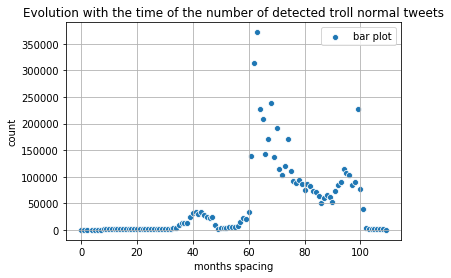

In [38]:
# plot purposes (whole data without truncating and
# without keeping only observations during the presidential campaign)
plt.figure(1)
sns.scatterplot(x = "months spacing", y="count", data=normal_dates_pd)
plt.title('Evolution with the time of the number of detected troll normal tweets')
plt.grid()
plt.xlabel('months spacing')
plt.ylabel('count')
plt.legend(['bar plot']);

We observe a peak starting after 61 months from May 2009 , thus in June 2014. This corresponds exactly to one year prior the moment when Donald Trump announced his candidacy for the primaries (republican) [wikipedia/donald_trump](https://en.wikipedia.org/wiki/Donald_Trump#Political_activities_up_to_2015). 

We'll have to determine whether the ***effective*** troll campaign did really (if it existed) start that month ; maybe to trigger in advance the aimed public.

After the peak the *troll* fever seems to drop monotically until 85 months after the very first tweets : it corresponds to June 2016 before growing up again **right before the final US elections** of november 2016). 

Trolls end after 100 months, at the beginning of the academic year 2017-2018 (Sep. 2017).

### => time window :  2014 -  2016

For the current Milestone, let's focus on that period of time since it corresponds to the whole presidential campaign (+ some time before as a flourishing speculative period)

Let's get some basic statistics about the feature *retweet_count* of that same *normal_tweets* dataframe. It could help us for our future analysis to evaluate/assess the importance of troll tweets. We do not dispose of view counts (at least for now) for such tweets but what can be sure is that there exists a correlation between the number of views and the number of retweets (the more a post is retweeted, the more likely that it reaches more and more people across the internet).

We can compare the summary statistics of *retweet_count* of normal tweets with statistics of typical 'popular' tweets on Twitter to get a kind of 'popularity scale'. Of course we have to be careful with the data we're dealing with : there might be some automatic retweet nested chains that would bias those results. We'll have to inform ourselves slightly more about that.

In [39]:
# get only the retweets counts (for years of interest, @tune)
normal_retweets_query = """SELECT retweet_count AS retweets
                        FROM normal_tweets_sql
                        WHERE YEAR(tweet_time)<2017 AND YEAR(tweet_time)>2013
                     """
normal_retweets_df = spark.sql(normal_retweets_query)

# relative error tolerance for median computation 
tol = 0.001

print('Summary statistics for RT counts for normal_tweets : ')
print('----------------------------------------------------')
normal_retweets_df.select('retweets').describe().show()
print('approx. 1st quarter quantile : '+str(normal_retweets_df.approxQuantile('retweets',[0.25],tol)[0])+\
      ' for relative error of '+str(tol))
print('approx. median : '+str(normal_retweets_df.approxQuantile('retweets',[0.5],tol)[0])+\
      ' for relative error of '+str(tol))
print('approx. 3rd quarter quantile : '+str(normal_retweets_df.approxQuantile('retweets',[0.75],tol)[0])+\
      ' for relative error of '+str(tol))

Summary statistics for RT counts for normal_tweets : 
----------------------------------------------------
+-------+-----------------+
|summary|         retweets|
+-------+-----------------+
|  count|          4034671|
|   mean|3.648541603516123|
| stddev|84.69370646803212|
|    min|                0|
|    max|            97498|
+-------+-----------------+

approx. 1st quarter quantile : 0.0 for relative error of 0.001


KeyboardInterrupt: 

**We presume that the vast majority of the normal tweets aren't given any RT!**

The *stddev* is huge, those statistics seem to indicate a ***power law*** distribution. 

Let's get the count distribution of the number of RT's. It fits into the memory since we only consider one column of $\simeq$ 5M observations. Nevertheless we won't store the Pandas for the rest of this notebook.

In [ ]:
# let's discover the number of normal tweets that were RT more than 10 times
normal_retweets_sup1_query = """SELECT retweet_count AS retweets
                        FROM normal_tweets_sql
                        WHERE retweet_count>10 AND YEAR(tweet_time)<2017 AND YEAR(tweet_time)>2013
                     """
normal_retweets_sup1_df = spark.sql(normal_retweets_sup1_query)

In [ ]:
# => RT count distribution

## log scale - truncated

# plot purpose  
plt.figure(1)
nbins_global = 100
sns.distplot(normal_retweets_sup1_df.select('retweets').toPandas().apply(lambda x: np.log10(x)),\
             bins = nbins_global, norm_hist = False, kde = False)
plt.title('Distribution of the frequency of the number of retweets for normal tweets : ' +\
          str(nbins_global)+' bins')
plt.xlabel('# of retweets (log scale)')
plt.ylabel('Frequency')
plt.grid()
plt.legend(['histogram']);

The proportion of normal tweets that have been only RT less than 10 times is gigantic. 

In [ ]:
# compute the required proportion
n_normal_RT_less10 = normal_retweets_df.count() - normal_retweets_sup1_df.count()

# print the results
print('proportion of normal tweets RT less than 10 times : '+str(n_normal_RT_less10/n_normal * 100)+'%')

No need to worry already : this is not sufficient evidence that there were no political inference through troll tweets during the US campaign of 2016. 

***But it actually may sustain the hypothesis of the existence of clever RT chains that relay the troll across the web at 'low cost' in terms of RTs.***

We will investigate why there are for the vast majority of the normal tweets, at first sight, so few RT's and if this phenomenon also arises on the reduced time windows mentionned earlier.

In [ ]:
# @continue..

_________________________________________________________________________________________________

Still it can be interesting to extract the most RT normal tweets and have a look at their content (we keep the *tweetid*'s). 

We may also want to discover what is the langage used and to which accounts are linked these tweets (we also keep *userid*).

In [ ]:
# get the 1000 (it could be more or less) most RT tweets

normal_retweets_top_query = """SELECT tweetid as id, userid AS user,retweet_count AS retweets,tweet_time
                        FROM normal_tweets_sql
                        WHERE YEAR(tweet_time)<2017 AND YEAR(tweet_time)>2013 
                        ORDER BY retweet_count DESC
                        LIMIT 1000
                     """
normal_retweets_top_df = spark.sql(normal_retweets_top_query)

# in order to have direct access on the computed top RT tweets (COMMENT IF LARGE TOP)
normal_retweets_top_df.persist()

# create temporary Spark SQL view 
normal_retweets_top_df.createOrReplaceTempView("normal_retweets_top_sql")

normal_retweets_top_df.show(20)

Let's join to this table some features of interest as the language of the tweet, the self-reported location of the author (***maybe highly corrupted***), whether or not the tweet did embed a poll plug-in (this feature is maybe more important than *a priori* believed : answering a poll insidiously bias people) , the content of the tweet and finally author's number of followers.

In [ ]:
# multiple JOIN instruction
informative_table_top_query = """
WITH tweets_stats_content AS (SELECT id, tweet_language, user, retweets ,tweet_text,tweet_time FROM normal_retweets_top_sql JOIN tweets_text_sql ON normal_retweets_top_sql.id = tweets_text_sql.tweetid),
all_but_localisation AS (SELECT tweetid, tweet_language, user, retweets ,tweet_text, follower_count as follow_numb, following_count as follow_cnt, tweet_client_name,tweet_time FROM tweets_stats_content JOIN tweets_meta_sql ON tweets_stats_content.id = tweets_meta_sql.tweetid),
all AS (SELECT user_reported_location, tweetid, tweet_language, user, retweets ,tweet_text, follower_count, following_count, tweet_client_name , tweet_time FROM all_but_localisation JOIN tweets_user_sql ON all_but_localisation.user = tweets_user_sql.userid)
SELECT user_reported_location, tweetid, tweet_language, user, retweets ,tweet_text, follower_count, following_count, tweet_client_name , YEAR(tweet_time) AS year, MONTH(tweet_time) AS MONTH FROM all
"""

Let's save the last result into a Parquet file !

In [ ]:
# comment if already computed 
spark.sql(informative_table_top_query).write.mode('overwrite').parquet("informative_table_top")

Let's load the previously built Spark data frame in Parquet's format.

In [ ]:
# read Parquet file
informative_table_top_df = spark.read.parquet("informative_table_top")

# load into Pandas (comment if large top)
informative_table_top_pd = informative_table_top_df.toPandas()

# quick review
informative_table_top_pd.head()

Among the last table there seem to be really intricating tweets ! 

In [ ]:
# user spotted as being a troll but doesn't have necessarily any link with russia
troll_example_df = informative_table_top_pd[informative_table_top_pd.user=='4224729994']
troll_example_df


In [ ]:
# example of two troll tweets that may have some psychological impact on readers
troll_example = troll_example_df.loc[38]
troll_example2 = troll_example_df.loc[4]

# their content speaks for itself ...
troll_example['tweet_text']
troll_example2['tweet_text']

These tweets were produced during the presidential campaign (September 2016).
___________________________________________________________________________

Let's have a look at summary statistics about features of our dataframe (fields of interest of the most RT tweets).

In [ ]:
# descriptive statistics of numerical fields
# (other than year or months that can ben considered as categorical in some sense)
informative_table_top_pd[['retweets','follower_count','following_count']].describe()

We can already see that the most RT tweets among our databases of troll tweets during the US presidential are produced by quite influent Twitter Accounts (median $\simeq 50$k). 

We've spent more time on exploring the questions 3) and 4) but we will further investigate this dataframe because it contains precious informations. Of course, it's likely that we're gonna choose not only the 1000 top RT normal tweets but maybe far more. 

In that latter case some of the previous computations may require Ada's cluster, without being certain for now. 

**We will investigate possible correlations betwen the number of normal tweets (of a certain kind; a filter has still to be constructed to assess the relevancy of those tweets) with Trump's popularity during the time window June 2014 - September 2017.** Therefore we first have to enrich our datasets with the popularity scores of Trump (and actually other opponents as there might be troll tweets aimed to discredit other candidates).

In [ ]:
# investigate correlation between number of normal tweets with Trump's
# popularity during that time window (June 2014-September 2017)

# @ complete

**We will try to catch where do the troll tweets come from and where do they spead.** To this purpose we also have to enrich our dataset with some studies. But unlike the previous point, we are not sure about the existence of such piece of information.

In [ ]:
# dig further into the 'importance' assessment of our troll tweets / try to figure out which 
# population had been 'touched' by the trolls 
# => we will try to infere this from the reported locations but some extra readings/thoughts are
# needed to ensure the validity of this process.

# @complete

To summarize, we have all the tools to answer to questions 1) and 2) properly thanks to the web-pages informed above. 

Only the last sub-question (actually not part of 1) nor 2), it's an extra) about the origin of troll tweets will be a bottleneck to overcome looking at more ressources on the internet ; if no satisfying ressource(s) is/are found, we will probably not answer it.

### Textual analysis
In order to answer to the questions 3) and 4) , or at least, to have a better insight on what we can do in the future, we must interest ourselves in the text of the tweets itself.

**Languages**

The first natural step is to identify the different languages present in our database. Let's group the tweets by languages and see which languages we will have to deal with.

In [ ]:
tweets_text_df.createOrReplaceTempView("tweets_text_sql") # Create temporary view to perform SQL operations

query_language = """WITH lang_counts AS (SELECT tweet_language, COUNT(tweet_language) AS language_count FROM tweets_text_sql GROUP BY tweet_language)
SELECT * FROM lang_counts ORDER BY language_count DESC LIMIT 20"""

language_count_df = spark.sql(query_language)

language_count_df.show()

# We can then draw a bar plot
language_count_df.toPandas().plot.bar(x = "tweet_language", y = "language_count",legend=False, 
                                      title="The 20 most frequent languages in tweets",grid=True)

We can see that there are a big variety of languages but the two big winners are the 'english' and the 'russian'. We will focus on those two for the moment.

We now have to identify the main subjects discussed in each tweet. Unfortunately none of us can speak russian, we nevetherless can translate these tweets with py-translate (Note that the translation is far from being perfect but at least we will have a global idea of what the tweets talk about).

First let us restrict ourselves to the english and russian tweets.

In [ ]:
df_ru = spark.sql("""SELECT * FROM tweets_text_sql WHERE tweet_language = 'ru'""")
df_en = spark.sql("""SELECT * FROM tweets_text_sql WHERE tweet_language = 'en'""")
df_ru.show()
df_en.show()

Now let us translate the russian tweets into english !

In [ ]:
translator= Translator(from_lang="russian",to_lang="english") # Initialise the russian translator
df_ru_translated = df_ru.rdd.map(lambda r: (r[0],r[1],translator.translate(r[2]))) # Translate the tweets

df_ru_translated = spark.createDataFrame(df_ru_translated) # New dataframe
df_ru_translated.show()

The translators in python are all querying translation websites. They don't like us to ask them to translate 5 000 000 tweets. This is why they ban our ID after too many translations. For Milestone 3, we should use the free trial google translation API to translate our tweets, save them into a parquet and cancel our free trial offer. 

For this milestone we will thus just focus on the english tweets.

**Hashtags**

Another important aspect of the tweets are the hashtags. They represent a lot of information as they can tell about the subject of the tweet, the opinion of the tweeter, ...

In [ ]:
# Introduce a pattern to match into the form of a regexp
regexp = re.compile("\B#\w\w+",re.IGNORECASE)

# @goal : return all the matching expressions : i.e. '#word will be transformed to ['word']
def tag_split(text):
    return regexp.findall(text)

# Apply this first map in order to flatten expressions of the type #word1#word2 ... 
flattered_tweets = df_en.rdd.map(lambda r: (r[0],r[1],tag_split(r[2])))

# Going back to dataframes to enjoy the "explode" methods that does exactly what we need
tweets_new_df = spark.createDataFrame(flattered_tweets, ['tweetid','tweet_language','tweet_text'])

# Create another SQL view for questions with this new representation
tweets_new_df.withColumn('hashtag', explode(tweets_new_df.tweet_text)).createOrReplaceTempView("tweets_flat_sql")

In [ ]:
# Select the 20 most frequent hashtags
pre_query = """WITH hashtag_freq AS(SELECT hashtag, COUNT(tweetid) AS frequency FROM tweets_flat_sql GROUP BY hashtag)
SELECT * FROM hashtag_freq ORDER BY frequency DESC LIMIT(20)"""

hashtags_count_df = spark.sql(pre_query)
hashtags_count_df.show()

# Plot purposes
hashtags_count_df.toPandas().plot.bar(x = "hashtag", y = "frequency",legend=False, title="The 20 most dominant hashtags",grid=True)

As we can see the most used hashtags are those about news, sports and politics. This makes sense as these 3 topics are actively debated by all tweeter's users, trolls included

**Words**

Now that we have analysed the hashtags, let us focus on the words themselves. This allows to see what are the typical words used by trolls. A comparison between most frequent words between troll and normal tweets is one of the nice plus that we could do for Milestone 3.

Note : we will remove the hastags words for this analysis

Let us first clean the tweets. Indeed a tweet contains a lot of noisy information i.e. links, RT, @somebody, #word, ...

Furthermore, a lot of variants of the same words exists. This is why we can use stemming to bring every word into its most reduced form.

Finally, every tweet contains stopwords i.e. words that we must use to build sentence but don't bring any particuliar information on the tweet itself (e.g. 'it', 'me', 'then', ...). These words can be removed to do some particuliar analysis.

**NOTE** : *'Hardcoding stopwords may seem to be bad practice but actually these are really problem specific and stackoverflow actually advised us to do it'*

[StackOverflow](https://stackoverflow.com/questions/19130512/stopword-removal-with-nltk)

In [ ]:
stemmer = nltk.SnowballStemmer("english")  # Initialize stemmer that 'kills' also stopwords
# custom list of stopwords
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself',
             'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
             'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these',
             'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do',
             'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
             'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
             'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
             'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
             'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
             'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've',
             'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn',
             'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn', 'make', 'go', 'get', "it's", 'us', '&amp;',
            'want', 'get', 'new', "don't", "i'm", 'one', 'say']

def tweet_cleaner(text, stem_option = True):
    """This function takes a String as input and returns a 'cleaned' version of it.
    -> No punctuation
    -> No links, hashtags, ...
    -> Stemming if stem_option = True"""
    text = re.sub(r'[.,"!,-]+', '', text, flags=re.MULTILINE)  # removes the characters specified
    text = re.sub(r'^RT[\s]+', '', text, flags=re.MULTILINE)  # removes RT
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)  # remove link
    text = re.sub(r'[:]+', '', text, flags=re.MULTILINE)
    new_line = ''
    for i in text.split():  # remove @ and # words
        stemmed_word = stemmer.stem(i)
        if not i.startswith('@') and not i.startswith('#') and stemmed_word not in stopwords:
            new_line += stemmed_word + ' '
    return new_line

In [ ]:
flattered_tweets = df_en.rdd.map(lambda r: (r[0],r[1],tweet_cleaner(r[2]).split()))

# Going back to dataframes to enjoy the "explode" methods that does exactly what we need
tweets_new_df = spark.createDataFrame(flattered_tweets, ['tweetid','tweet_language','tweet_text'])

# Create another SQL view for questions with this new representation
tweets_new_df.withColumn('words', explode(tweets_new_df.tweet_text)).createOrReplaceTempView("tweets_flat_sql")

In [ ]:
# Select the 20 most frequent words
pre_query = """WITH word_freq AS(SELECT words, COUNT(tweetid) AS frequency FROM tweets_flat_sql GROUP BY words)
SELECT * FROM word_freq ORDER BY frequency DESC LIMIT(20)"""

words_count_df = spark.sql(pre_query)
words_count_df.show()

# Plot purposes
words_count_df.toPandas().plot.bar(x = "words", y = "frequency",legend=False, title="The 20 most dominant words",grid=True)

Without any surprise the most frequent word is trump. Some other interesting words also appear such as 
* obama : Obama was a great supporter of the main opponent of Trump that is Hillary Clinton. A theory would be that the trolls tried to discredit Obama's opinion
* black : A word with a negative connotation. Trump supporters are considered by many to be racist.
* kill : Again another word with negative connotation. A lot of interpretations are possible here.

**Semantic analysis**

We can now finally try to analyse the construction of each tweet, what it talks about, the subjects of each tweet.

Let us focus here on a toy example of 1000 tweets and clean those tweets (conserving the stopwords and not stemming !)

In [ ]:
df_en.createOrReplaceTempView("tweets_text_en_sql") # Create temporary view to perform SQL operations
toy_example = spark.sql("""SELECT tweet_text FROM tweets_text_en_sql LIMIT 1000""")

toy_example_pd = toy_example.toPandas()
print('Tweets before cleaning : ' + str(toy_example_pd) + '\n')
toy_example_cleaned = toy_example_pd.apply(lambda x : tweet_cleaner(x, stem_option = False))
print('Tweets after cleaning : ' + str(toy_cleaned))

We can clearly see that the data is now much more suitable for performing text processing operations. 

The library we will use is called spacy. It is an open-source library that provides a bunch of text-processing functions (these operations are performed using neural networks).

The main operation that the library provides is the **nlp function** which allows us to derive what the tweet is talking about by identifying identities such as PERSON, ORG, DATE, ...

In [ ]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en') # 'en' for english analysis

# Loop through every tweet and perfrom text analysis
for i, tweet in enumerate(toy_cleaned):
    print(tweet)
    print('Analysis of tweet ' + str(i) + '\n')
    analysis = nlp(tweet)
    # Find named entities, phrases and concepts
    for entity in analysis.ents:
        print(entity.text, entity.label_)
    print('\n')

As we can see, the semantic analysis is (barely) not working ! The tweets are just too short sentences and/or are using too many links/hashtags, getting in the way of the global understanding of the tweet.

Studying the semantic of the tweets is therefore a (too) complicated operation, which may be dropped for next milestone.

### Support or hate ?

This question is quite difficult to answer such prematurely. However, what we can do for now is what is called a ***sentiment analysis***. This problem is a machine learning classification problem that tries to classifiy a tweet as 'positive' or 'negative'. While it doesn't totally answer to the question 5), it is still a good start that could be reused afterwards.

The first step of a sentiment analysis is to define words that we consider to be respectively positive, negative.

In [ ]:
def read_file(file):
    f = open(file, 'r')
    words = []
    for word in f:
        words += [word[:len(word)-2]]
    f.close()
    return words


neg_words = read_file('negative.txt')
print('Negative words : ' + str(neg_words))
pos_words = read_file('positive.txt')
print('Positive words : ' + str(pos_words))